In [1]:
import apoc
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
import numpy as np

cl.OCLArray([[4496., 5212., 6863., ..., 2917., 2680., 2642.],
       [4533., 5146., 7555., ..., 2843., 2857., 2748.],
       [4640., 6082., 8452., ..., 3372., 3039., 3128.],
       ...,
       [1339., 1403., 1359., ..., 4458., 4314., 4795.],
       [1473., 1560., 1622., ..., 3967., 4531., 4204.],
       [1380., 1368., 1649., ..., 3091., 3558., 3682.]], dtype=float32)
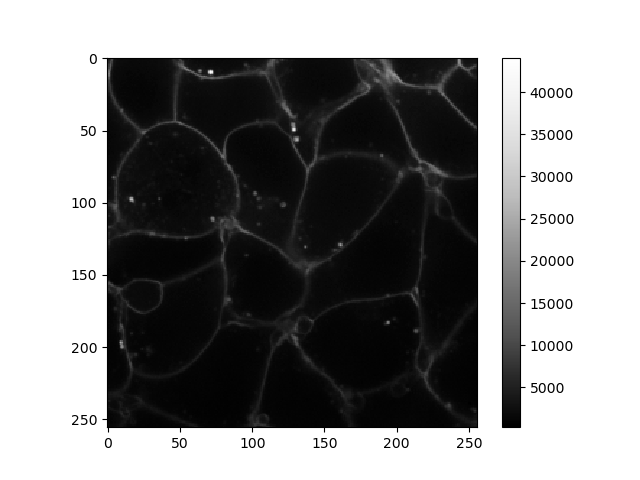
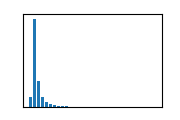

In [2]:
image = imread('membrane2d.tif')
cle.asarray(image)

cl.OCLArray([[0.8514066 , 1.0200942 , 1.3921092 , ..., 0.6749894 , 0.6340478 ,
        0.6390664 ],
       [0.8397066 , 0.9866097 , 1.5033678 , ..., 0.6544611 , 0.6719634 ,
        0.6603491 ],
       [0.8410301 , 1.1425375 , 1.6502894 , ..., 0.7734034 , 0.7116847 ,
        0.747907  ],
       ...,
       [0.6833182 , 0.70865285, 0.6797715 , ..., 1.5903093 , 1.5137495 ,
        1.6566108 ],
       [0.7665792 , 0.8030892 , 0.8264799 , ..., 1.3939476 , 1.5649658 ,
        1.4287568 ],
       [0.73148733, 0.71694326, 0.85501015, ..., 1.0721965 , 1.2123575 ,
        1.2338016 ]], dtype=float32)
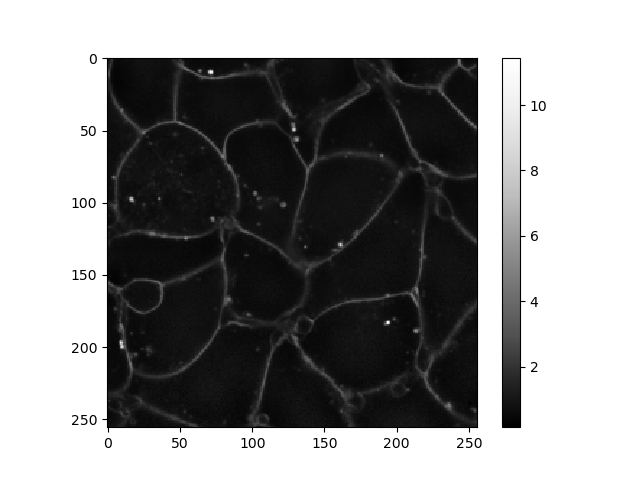
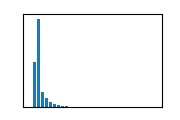

In [3]:
background_subtracted = cle.divide_by_gaussian_background(image, sigma_x=10, sigma_y=10)
background_subtracted

cl.OCLArray([[  1,   1,   1, ...,   7,   7,   7],
       [  1,   1,   1, ...,   7,   7,   7],
       [  1,   1,   1, ...,   7,   7,   7],
       ...,
       [247, 247, 247, ..., 262, 262, 262],
       [247, 247, 247, ..., 262, 262, 262],
       [247, 247, 247, ..., 262, 262, 262]], dtype=uint32)
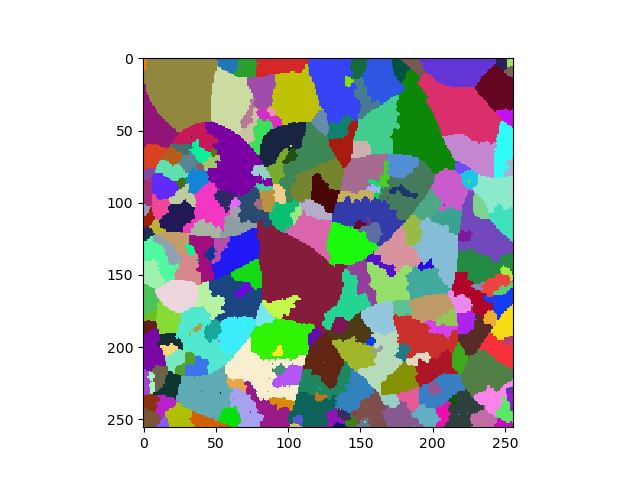

In [4]:
oversegmented = imread("membrane2d_oversegmented.tif")
cle.asarray(oversegmented).astype(np.uint32)

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


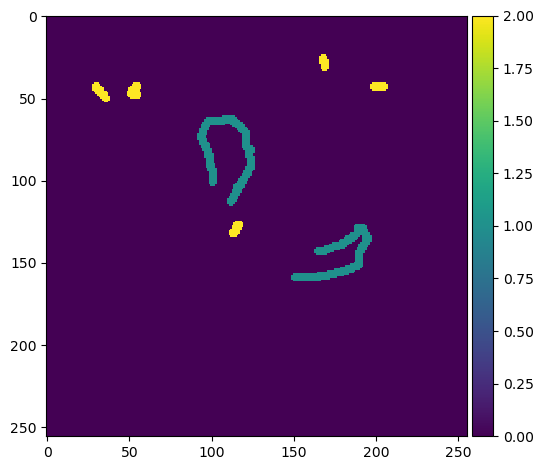

In [5]:
annotation = imread("membrane2d_merge_annotation.tif")
imshow(annotation)

In [6]:
def make_should_touch_matrix(annotation_binary_mask, labels):
    
    touch_matrix = cle.create_square_matrix_from_labelmap(labels)
    
    masked_labels = cle.mask(labels, annotation_binary_mask)
    
    cle.generate_touch_matrix(masked_labels, touch_matrix)
    
    # ignore touching background
    cle.set_column(touch_matrix, 0, 0)
    cle.set_row(touch_matrix, 0, 0)
    
    return touch_matrix


cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
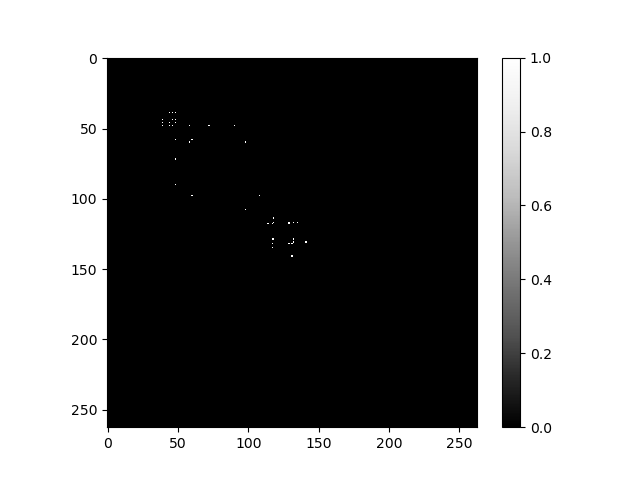
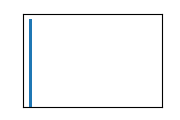

In [7]:
should_touch_matrix = make_should_touch_matrix(annotation == 1, oversegmented)
should_touch_matrix

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
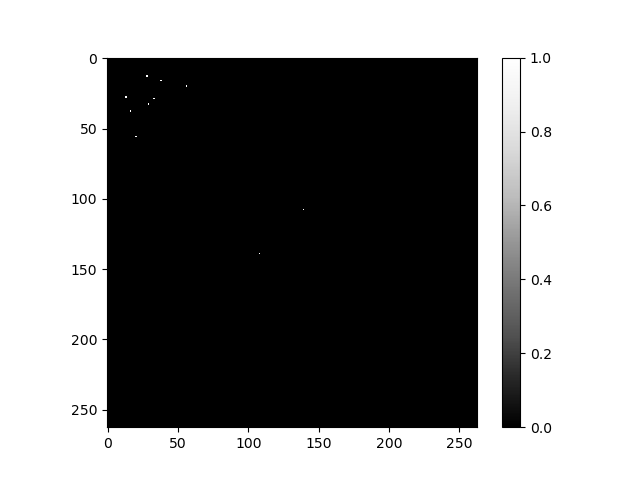
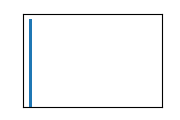

In [8]:
should_not_touch_matrix = make_should_touch_matrix(annotation == 2, oversegmented)
should_not_touch_matrix

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
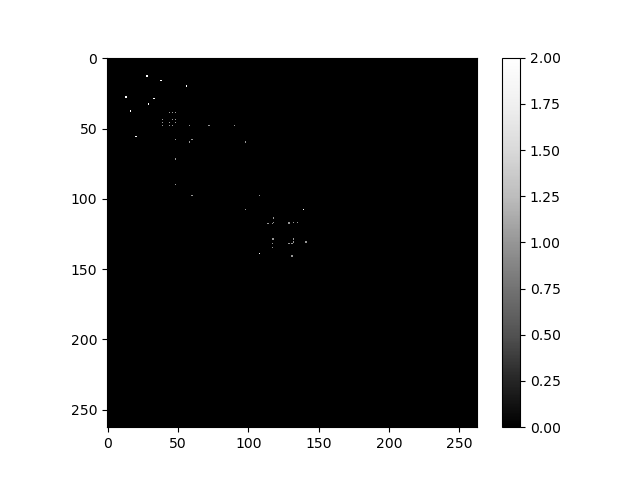
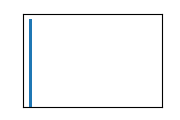

In [9]:
ground_truth_matrix = should_touch_matrix + should_not_touch_matrix * 2
ground_truth_matrix

cl.OCLArray([[nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
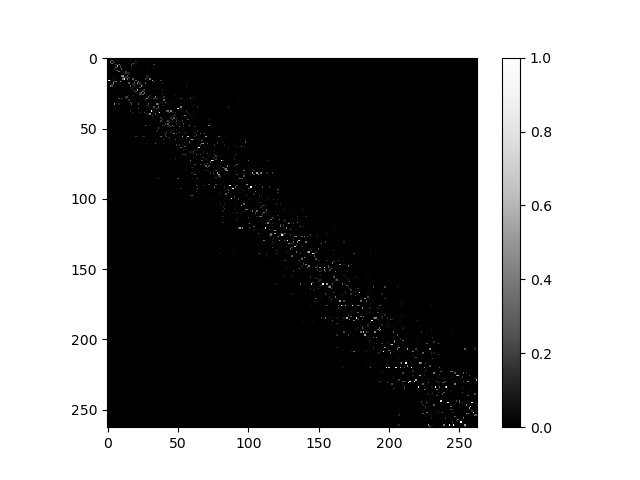
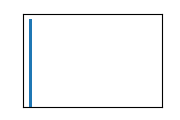

In [10]:
touch_portion_matrix = cle.generate_touch_portion_matrix(oversegmented)
touch_portion_matrix

cl.OCLArray([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
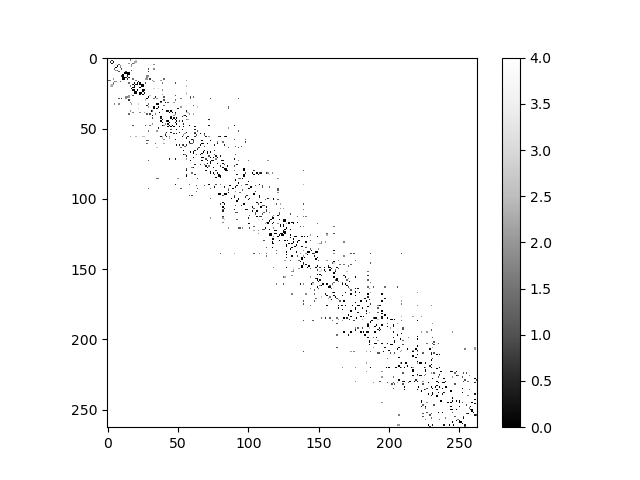
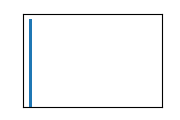

In [11]:
touch_intensity_matrix = cle.generate_touch_mean_intensity_matrix(background_subtracted.astype(int), oversegmented)
touch_intensity_matrix

In [12]:
classifier = apoc.PixelClassifier()

feature_definition = "original"

data = [touch_portion_matrix, touch_intensity_matrix]

classifier.train(features=feature_definition,
                 ground_truth=ground_truth_matrix,
                 image=data) 

cl.OCLArray([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)
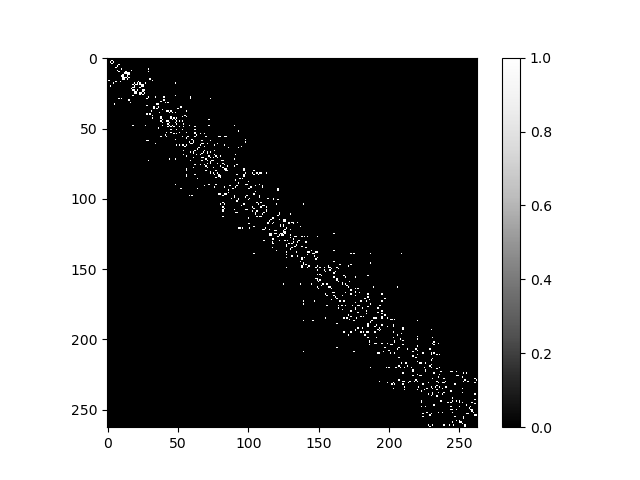
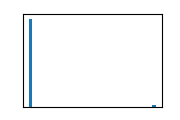

In [13]:
merge_matrix = classifier.predict(image=data) == 1
merge_matrix

cl.OCLArray([[  5,   5,   5, ...,   2,   2,   2],
       [  5,   5,   5, ...,   2,   2,   2],
       [  5,   5,   5, ...,   2,   2,   2],
       ...,
       [138, 138, 138, ..., 145, 145, 145],
       [138, 138, 138, ..., 145, 145, 145],
       [138, 138, 138, ..., 145, 145, 145]], dtype=uint32)
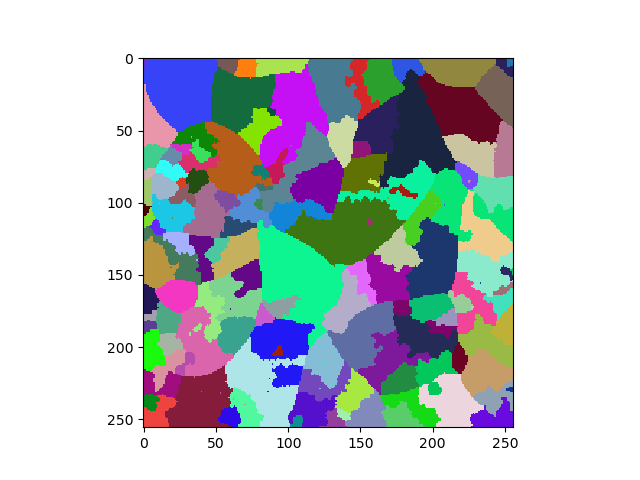

In [14]:
cle.merge_labels_according_to_touch_matrix(oversegmented, merge_matrix)

In [15]:
def merge_labels(image, labels, classifier):
    touch_portion_matrix = cle.generate_touch_portion_matrix(labels)
    touch_intensity_matrix = cle.generate_touch_mean_intensity_matrix(image.astype(int), labels)
    data = [touch_portion_matrix, touch_intensity_matrix]
    
    merge_matrix = classifier.predict(image=data) == 1
    
    return cle.merge_labels_according_to_touch_matrix(labels, merge_matrix)

cl.OCLArray([[  5,   5,   5, ...,   2,   2,   2],
       [  5,   5,   5, ...,   2,   2,   2],
       [  5,   5,   5, ...,   2,   2,   2],
       ...,
       [138, 138, 138, ..., 145, 145, 145],
       [138, 138, 138, ..., 145, 145, 145],
       [138, 138, 138, ..., 145, 145, 145]], dtype=uint32)
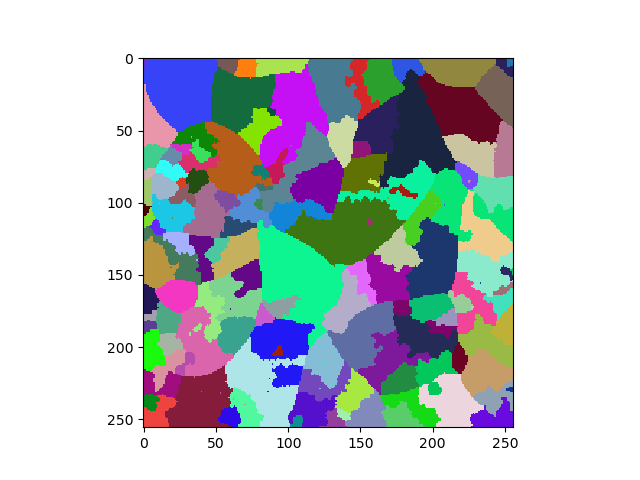

In [17]:
labels = merge_labels(background_subtracted, oversegmented, classifier)
labels

cl.OCLArray([[ 6,  6,  6, ...,  1,  1,  1],
       [ 6,  6,  6, ...,  1,  1,  1],
       [ 6,  6,  6, ...,  1,  1,  1],
       ...,
       [76, 76, 76, ..., 82, 82, 82],
       [76, 76, 76, ..., 82, 82, 82],
       [76, 76, 76, ..., 82, 82, 82]], dtype=uint32)
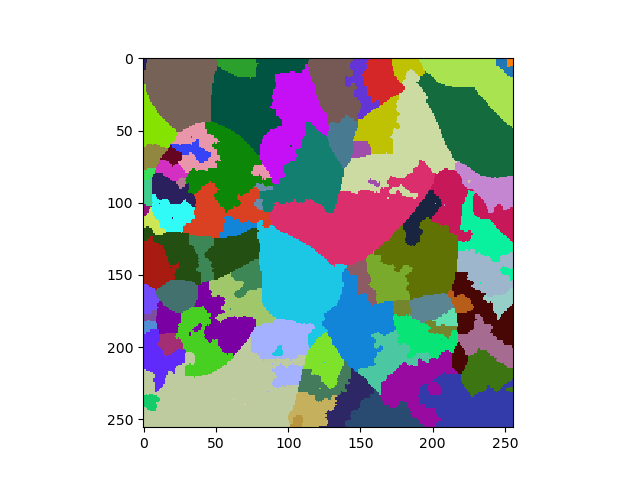

In [19]:
labels = merge_labels(background_subtracted, labels, classifier)
labels

cl.OCLArray([[ 4,  4,  4, ...,  1,  1,  1],
       [ 4,  4,  4, ...,  1,  1,  1],
       [ 4,  4,  4, ...,  1,  1,  1],
       ...,
       [46, 46, 46, ..., 51, 51, 51],
       [46, 46, 46, ..., 51, 51, 51],
       [46, 46, 46, ..., 51, 51, 51]], dtype=uint32)
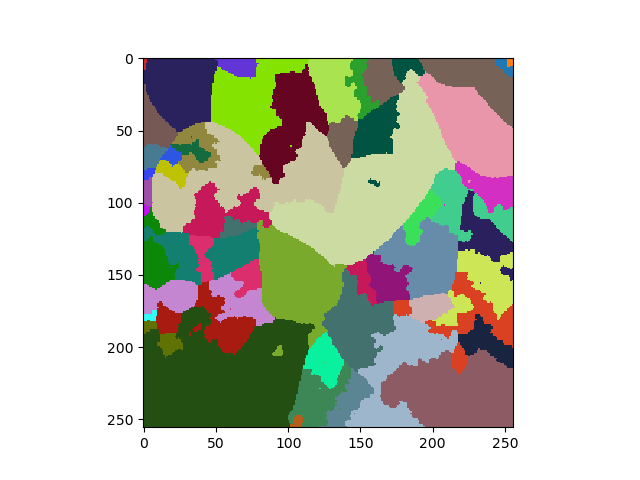

In [20]:
labels = merge_labels(background_subtracted, labels, classifier)
labels

cl.OCLArray([[ 2,  2,  2, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  1,  1,  1],
       ...,
       [30, 30, 30, ..., 34, 34, 34],
       [30, 30, 30, ..., 34, 34, 34],
       [30, 30, 30, ..., 34, 34, 34]], dtype=uint32)
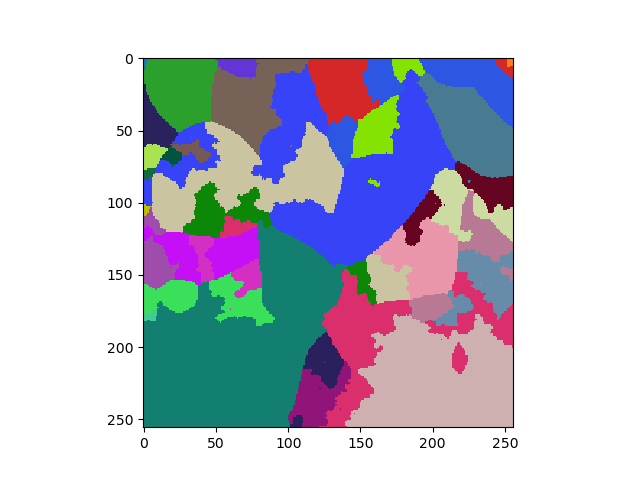

In [21]:
labels = merge_labels(background_subtracted, labels, classifier)
labels

cl.OCLArray([[ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       ...,
       [21, 21, 21, ..., 22, 22, 22],
       [21, 21, 21, ..., 22, 22, 22],
       [21, 21, 21, ..., 22, 22, 22]], dtype=uint32)
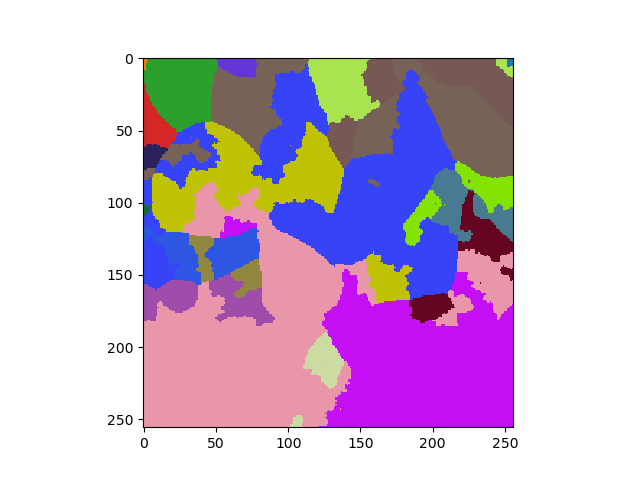

In [22]:
labels = merge_labels(background_subtracted, labels, classifier)
labels

cl.OCLArray([[ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       ...,
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]], dtype=uint32)
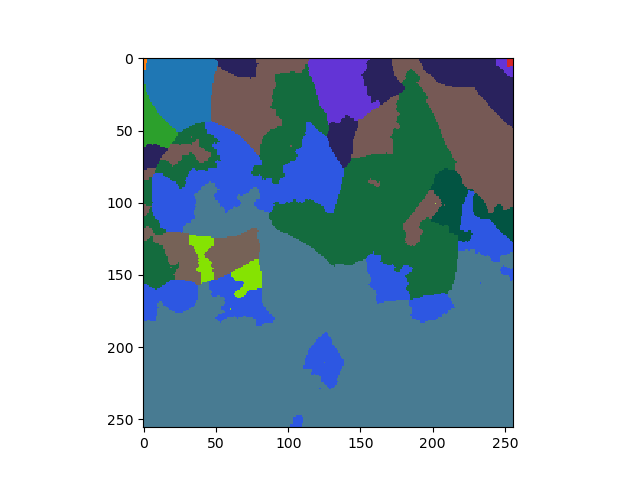

In [23]:
labels = merge_labels(background_subtracted, labels, classifier)
labels

cl.OCLArray([[1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       ...,
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9]], dtype=uint32)
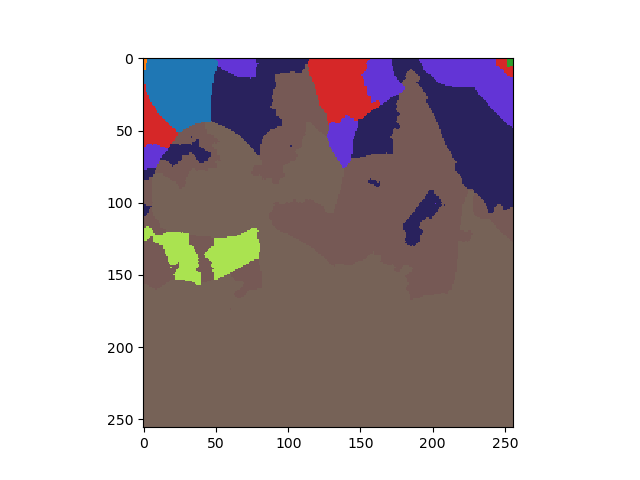

In [24]:
labels = merge_labels(background_subtracted, labels, classifier)
labels